# Transfer Learning
Given two things you'd like to distinguish, run a Google image search to download images, then train Resnet50 to distinguish them. 


<br> Training of Resnet50 model adapted from https://www.kaggle.com/dansbecker/transfer-learning

## Define objects and make directories

In [1]:
import os

thing1 = 'Grizzly bear'
thing2 = 'Teddy bear'

def clean_string(thing:str):
    return thing.lower().replace(" ", "_")

def make_project_dirs(project_dir):
    os.mkdir(project_dir)
    os.mkdir(f'{project_dir}/train')
    os.mkdir(f'{project_dir}/val')

thing1_processed = clean_string(thing1)
thing2_processed = clean_string(thing2)

project_name = thing1_processed + '_vs_' + thing2_processed
project_dir = f'../data/raw/{project_name}'
make_project_dirs(project_dir)

## Download images

In [2]:
from google_images_download import google_images_download 

response = google_images_download.googleimagesdownload()

def delete_non_jpegs(directory):
    non_jpgs = [f for f in os.listdir(directory) if f[-4:] != '.jpg']
    if len(non_jpgs) > 0:
        [os.remove(f'{directory}/{f}') for f in non_jpgs]

# We could randomly sample train/val, but for now we'll temporally separate
train_range = '{"time_min":"01/01/2010","time_max":"01/01/2015"}'
val_range = '{"time_min":"01/01/2015","time_max":"01/01/2018"}'
    
for i, thing in enumerate([thing1, thing2]):

    image_dir = str(i) + '_' + clean_string(thing)
    
    arguments = {"keywords":thing,"limit":50,"print_urls":False,
                'size':'medium', 'format':'jpg'}
    
    arguments.update({'output_directory':project_dir+'/train',
                      'image_directory':image_dir,
                      'time_range':train_range})
    paths = response.download(arguments)
    delete_non_jpegs(f'{project_dir}/train/{image_dir}')
    
    arguments.update({'output_directory':project_dir+'/val',
                      'image_directory':image_dir,
                      'time_range':val_range})          
    paths = response.download(arguments)
    delete_non_jpegs(f'{project_dir}/val/{image_dir}')


Item no.: 1 --> Item name = Grizzly bear
Evaluating...
Starting Download...
Completed Image ====> 1. grizzly-bear-harry-bosen-dpc.jpg
Completed Image ====> 2. grizzly_bear1.jpg
Completed Image ====> 3. gfximage-bears-distinctive-features.jpg
Completed Image ====> 4. img_grizzlybear_mh_large.jpg
Completed Image ====> 5. o-grizzly-bear-photographer-570.jpg
Completed Image ====> 6. gty_alaskan_brown_bear_jt_120826_wmain.jpg
Completed Image ====> 7. 50543_1_1280x720_640x360_177570883992.jpg
Completed Image ====> 8. grizzly-bear-1-728.jpg
Completed Image ====> 9. grizzly_momcub_ericb_000.jpg
Completed Image ====> 10. 53a2f17ea933d.image.jpg
Completed Image ====> 11. western_gorilla_vs_grizzly_bear.jpg
Completed Image ====> 12. mr_76994.jpg
Completed Image ====> 13. 16griz-jumbo.jpg
Completed Image ====> 14. bear-cubs.jpg
Completed Image ====> 15. 58613_1_1280x720_640x360_177555011733.jpg
Completed Image ====> 16. grizzlybear.jpg
Completed Image ====> 17. 1-img_7692ca_web1.jpg
Completed Ima

Completed Image ====> 50. wonder-36-teddy-bear-static-image.jpg

Errors: 0


Item no.: 1 --> Item name = Teddy bear
Evaluating...
Starting Download...
Completed Image ====> 1. 814f0n9%2byol._sy355_.jpg
Completed Image ====> 2. 41nggvyaxjl._sx425_.jpg
Completed Image ====> 3. giant-8-foot-teddy-bear-0.jpg
Completed Image ====> 4. 6_foot_life_size_teddy_bear_soft_pink_color_sweet_cuddly_teddybear_lady_cuddles-1__84298.1493916146.jpg
Completed Image ====> 5. ar-01595-2.jpg
Completed Image ====> 6. 51pluq6nbbl._sl500_ac_ss350_.jpg
Completed Image ====> 7. bb-1481-2.jpg
Completed Image ====> 8. 51yjnp1fjel._sl500_ac_ss350_.jpg
Completed Image ====> 9. s-l640.jpg
Completed Image ====> 10. pooh-teddy-bear-500x500.jpg
Completed Image ====> 11. 1517501957170_3.jpg
Completed Image ====> 12. 2112-3.jpg
Completed Image ====> 13. 12cm-little-flower-teddy-bears-cute-teddy-bear-wedding-gift-birthday-present-kids-toys-bear.jpg
Completed Image ====> 14. decorative-teddy-bear-basket-500x500.jpg
Complete

## Specify Model

In [3]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

num_classes = 2
resnet_weights_path = '../models/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

## Compile Model

In [4]:
my_new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

## Fit Model

In [5]:
%%time
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_directory(
        f'{project_dir}/train',
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        f'{project_dir}/val',
        target_size=(image_size, image_size),
        class_mode='categorical')

my_new_model.fit_generator(
        train_generator,
        steps_per_epoch=3,
        epochs=3,
        validation_data=validation_generator,
        validation_steps=1)

Found 96 images belonging to 2 classes.
Found 87 images belonging to 2 classes.
Epoch 1/3
3/3 [==============================] - 53s 18s/step - loss: 0.4058 - acc: 0.8194 - val_loss: 0.2360 - val_acc: 0.9688
Epoch 2/3
3/3 [==============================] - 49s 16s/step - loss: 0.2121 - acc: 0.9306 - val_loss: 0.1624 - val_acc: 0.9688
Epoch 3/3
3/3 [==============================] - 49s 16s/step - loss: 0.1382 - acc: 0.9444 - val_loss: 0.1110 - val_acc: 0.9688
Wall time: 2min 32s


In [6]:
import os
import numpy as np
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

# image_dir = '../data/raw/dogs-gone-sideways/val/upright'
# img_paths = [os.path.join(image_dir, filename) for filename in [os.listdir(image_dir), os.listdir(image_dir)]]

upright_dir = '../data/raw/dogs-gone-sideways/val/upright'
sideways_dir = '../data/raw/dogs-gone-sideways/val/sideways'

def list_all_files(dir):
    return [os.path.join(dir, f) for f in os.listdir(dir)]

img_paths = []
for i, thing in enumerate([thing1, thing2]):
    image_dir = str(i) + '_' + clean_string(thing)
    img_paths += list_all_files(f'{project_dir}/val/{image_dir}')

img_paths = np.random.choice(img_paths, 10, replace=False)
img_paths

# img_paths = np.random.choice(list_all_files(upright_dir) + list_all_files(sideways_dir), 10)

array(['../data/raw/grizzly_bear_vs_teddy_bear/val/1_teddy_bear\\50. cf6276_weighted_bear_silo.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/0_grizzly_bear\\28. ahr0cdovl3d3dy5saxzlc2npzw5jzs5jb20vaw1hz2vzl2kvmdawlza5mc82ndivb3jpz2luywwvz3jpenpses1izwfycy1jdwjzlmpwzw==.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/1_teddy_bear\\34. shy-teddy-bear-400x451-400x451.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/0_grizzly_bear\\9. bear-with-trout-270706-800px.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/1_teddy_bear\\10. pooh-teddy-bear-500x500.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/1_teddy_bear\\21. teddybeartoss-tw-520x380.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/0_grizzly_bear\\42. bear-blog-header.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/0_grizzly_bear\\46. grizzly-bear.jpg',
       '../data/raw/grizzly_bear_vs_teddy_bear/val/1_teddy_bear\\43. 022715_l__14836.1496427278.490.588.jpg',
       '.

In [7]:
test_data = read_and_prep_images(img_paths)
preds = my_new_model.predict(test_data)
preds_bin = [thing1 if preds[i,0] >= 0.5 else thing2 for i in range(0, len(preds))]
probs = np.max(preds, axis=1)

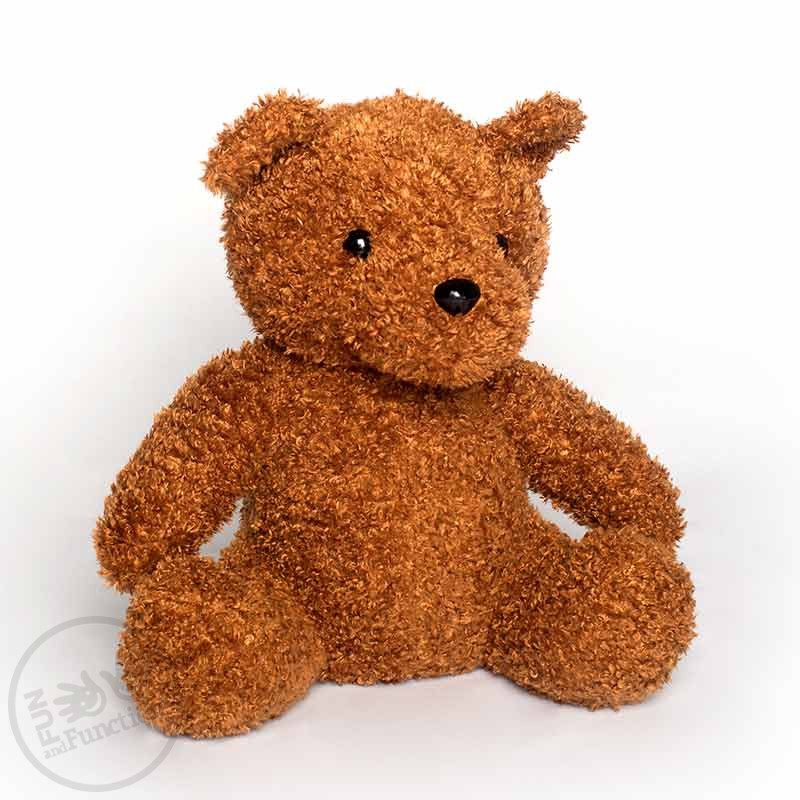

0.92754066 Teddy bear


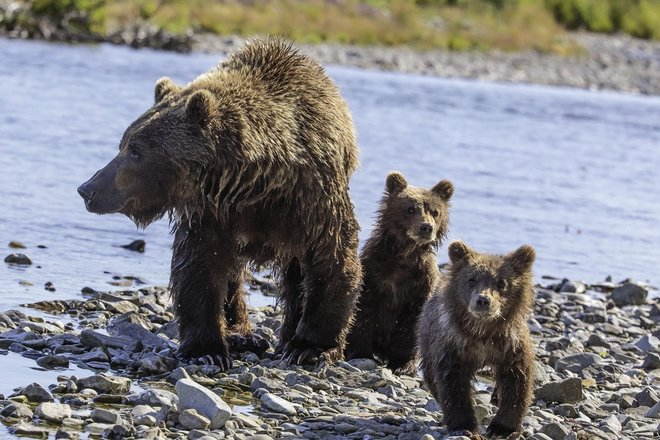

0.9921631 Grizzly bear


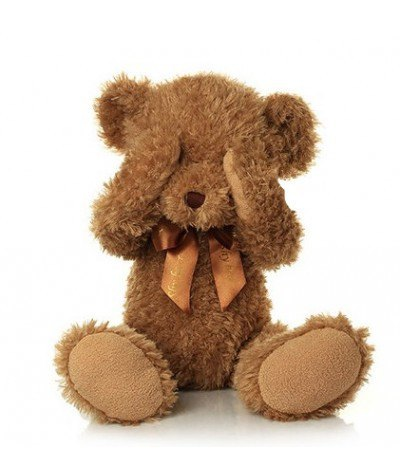

0.94480914 Teddy bear


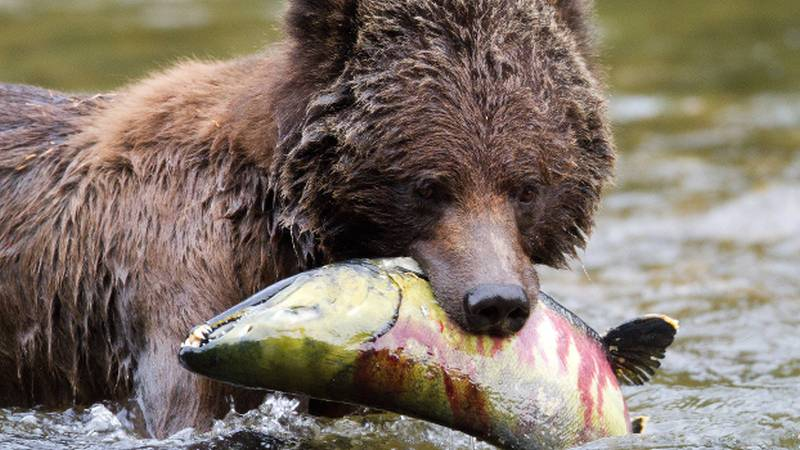

0.9877198 Grizzly bear


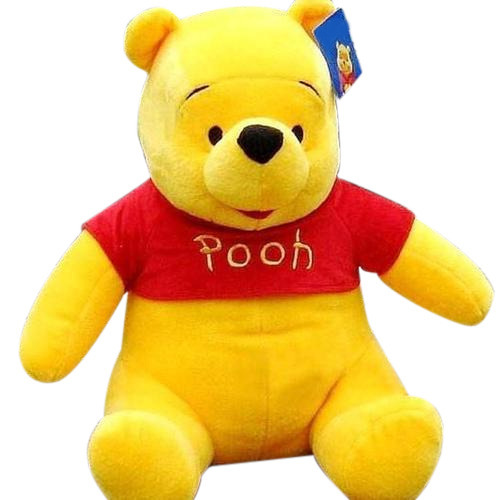

0.98340833 Teddy bear


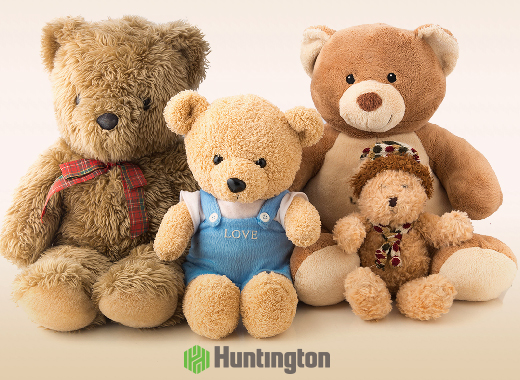

0.99074954 Teddy bear


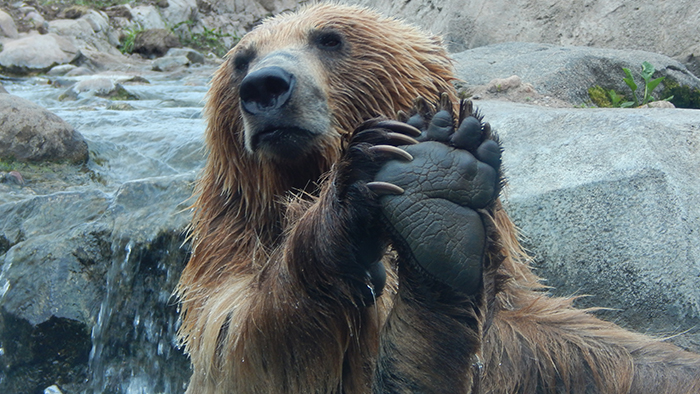

0.95596683 Grizzly bear


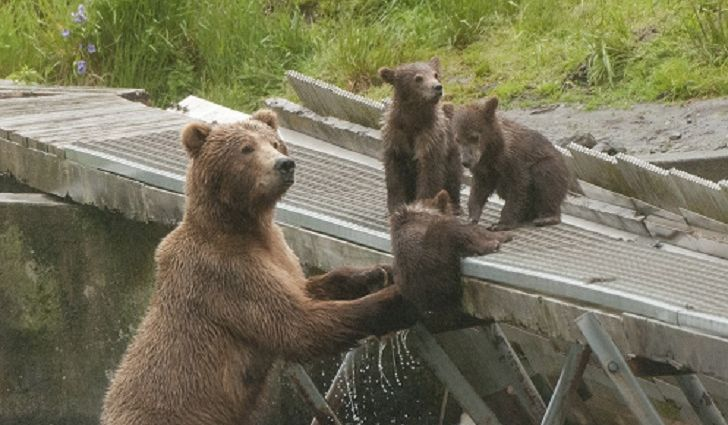

0.98714983 Grizzly bear


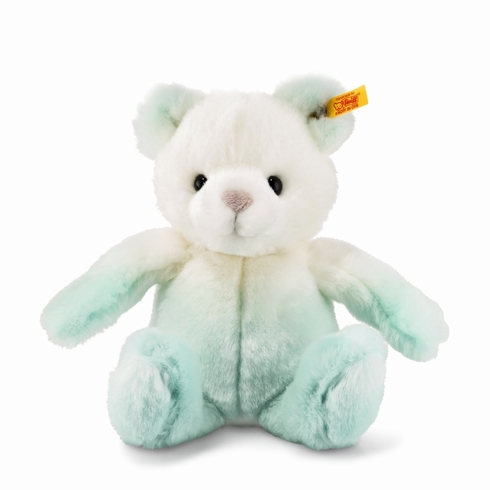

0.93568385 Teddy bear


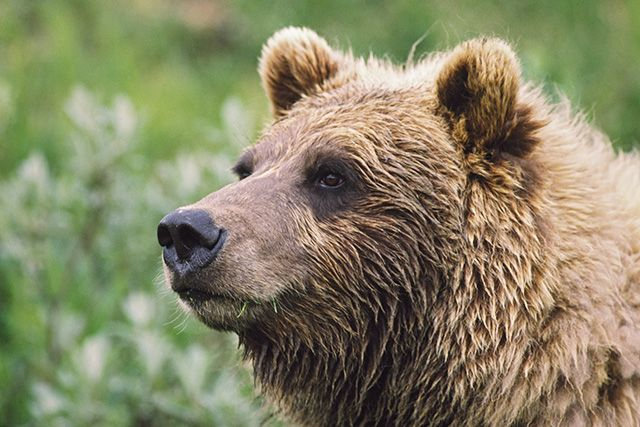

0.9471857 Grizzly bear


In [8]:
from IPython.display import Image, display

for i, img_path in enumerate(img_paths):
    display(Image(img_path))
    print(probs[i], preds_bin[i])